In [179]:
import numpy as np
import matplotlib.pyplot as plt
from FD_Vlasov_supp import *
import importlib
importlib.import_module('mpl_toolkits.mplot3d').__path__
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import numpy.linalg as la
import scipy as sci

% matplotlib inline
np.set_printoptions(precision = 8)

Solve Vlasov's equation in one space dimension and one velocity dimension:
\begin{equation}
\frac{\partial f}{\partial t} + v\frac{\partial f}{\partial x} + E(t,x)\frac{\partial f}{\partial v} = 0
\end{equation}
With $x \in (0,L)$ and $v \in (-\infty, \infty)$, and $\lim_{|v|\to \infty} f(t,x,v) = 0$

We also need boundary conditions for the spatial dimension, which will be periodic.

We'll use a cutoff velocity $L_v$ to define our computational domain for $v$.  The electric field will be defined as in the paper "Numerical Approximation of the One-Dimensional Vlasov-Poisson System with Periodic Boundary Conditions" (Wollman, Ozizmir) (with a change of sign for positive definiteness)
\begin{align}
-\frac{\partial^2 \Phi}{\partial x^2}(t,x) &=\int_{\mathbb{R}}f(t,x,v)dv -1\\
E(t,x) &= -\frac{\partial \Phi}{\partial x}
\end{align}
Electric field will have zero mean, which is equivalent to
\begin{equation}
\Phi(0)= \Phi(L) = 0
\end{equation}
The electric field will then be periodic provided that:
\begin{equation}
\int_0^L\int_{-\infty}^{\infty}f dv dx = L
\end{equation}
Integrating over $v$ accurately and preserving the value of the above integral for future times needs to be addressed.

Currently trying initial conditions given in numerical experiments section of "Comparison of Eulerian Vlasov Solvers" (Filbet and Sonnendrucker) (also in repo)

We'll discretize in space and velocity first.  This is a scalar conservation law:
\begin{equation}
\frac{\partial f}{\partial t} + \nabla \cdot \mathbf{F}(f) = 0
\end{equation}
where 
\begin{equation}
\mathbf{F}(f) = \begin{pmatrix}
vf\\
E(t,x)f \end{pmatrix}
\end{equation}
Couple of things to try here:

First, extend the 1d Lax-Friedrich's method dimension by dimension:
\begin{align}
f_{i,j}^{n+1} = &\frac{1}{2}(f_{i+1,j}^n + f_{i-1,j}^n + f_{i,j+1}^n + f_{i,j-1}) - f_{i,j}^n \\
& - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_{i-1,j}^n) - E(t_n,x_i)\frac{\Delta t}{2 \Delta v}(f_{i,j+1}^n - f_{i,j-1}^n)
\end{align}
This looks a tad weird so alternatively, one could try:
\begin{align}
f_{i,j}^{n+1} = &\frac{1}{4}(f_{i+1,j}^n + f_{i-1,j}^n + f_{i,j+1}^n + f_{i,j-1}) \\
& - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_
{i-1,j}^n) - E(t_n,x_i)\frac{\Delta t}{2 \Delta v}(f_{i,j+1}^n - f_{i,j-1}^n)
\end{align}

Finally, we could try dimensional splitting:
\begin{equation}
f_{i,j}^* = \frac{1}{2}(f_{i+1,j}^n + f_{i-1,j}^n) - v_j\frac{\Delta t}{2\Delta x}(f_{i+1,j}^n - f_{i-1,j}^n)
\end{equation}
first solving a 1d advection problem in $x$-direction (with smaller timestep) and then
\begin{equation}
f_{i,j}^n = \frac{1}{2}(f_{i,j+1}^* + f_{i,j-1}^*) - E(t_n,x_i)\frac{\Delta t}{2\Delta v}(f_{i,j+1}^* - f_{i,j-1}^*)
\end{equation}
an advection in the velocity direction.

Three methods are coded below

In [180]:
def FV_step_1(U,V,E,dt,dx,dv):
    # ordered as abo|ve
    U = 0.5*(np.roll(U,-1,axis = 1) + np.roll(U,1,axis = 1) \
    + np.roll(U,-1,axis = 0) + np.roll(U,1,axis = 0))-\
    U -V*(dt/(2*dx))*(np.roll(U,-1,axis = 1) - np.roll(U,1,axis = 1))-\
    E*(dt/(2*dv))*(np.roll(U,-1,axis = 0) - np.roll(U,1,axis = 0))
        
    U[0,:] = 0.0
    U[-1,:] = 0.0
    return U

def FV_step_2(U,V,E,dt,dx,dv):
    U = 0.25*(np.roll(U,-1,axis = 1) + np.roll(U,1,axis = 1) + \
              np.roll(U,-1,axis = 0) + np.roll(U,1,axis = 0))-\
    V*(dt/(2*dx))*(np.roll(U,-1,axis = 1) - np.roll(U,1,axis = 1))-\
        E*(dt/(2*dv))*(np.roll(U,-1,axis = 0) - np.roll(U,1,axis = 0))
        
    U[0,:] = 0.0
    U[-1,:] = 0.0
    return U

def FV_step_3(U,V,E,dt,dx,dv):
    U_temp = 0.5*(np.roll(U,-1,axis = 1) + np.roll(U,1,axis = 1))-\
    V*(dt/(2*dx))*(np.roll(U,-1,axis = 1) - np.roll(U,1,axis = 1))
        
    U = 0.5*(np.roll(U_temp,-1,axis = 0) + np.roll(U_temp,1,axis = 0))-\
    E*(dt/(2*dv))*(np.roll(U_temp,-1,axis = 0) -\
                   np.roll(U_temp,1,axis = 0))
        
    U[0,:] = 0.0
    U[-1,:] = 0.0
    return U

In [295]:
Lv = 40     # approximation to "infinity" for velocity space

# see paper for parameters
alpha = 0.01
k = 0.5
L = 2*np.pi/k  # length of spatial domain, which is periodic

# number of cells
nx = 64
nv = 228
dx = L/nx
dv = (2*Lv)/nv

# points are midpoints of each cell
x = np.arange(dx/2,L,dx)
v = np.arange(-Lv + dv/2,Lv,dv)

X,V = np.meshgrid(x,v)  # represent as grid

# "plasma echo"
# k = 0.483
def initial_u(x,v):
    z = np.exp(-(v**2)/2)
    z = z/(np.sqrt(2*np.pi))
    return z

# "nonlinear Landau Damping" - Linear until t < alpha^(-1/2)
# alpha = 0.5
def initial_u2(x,v):
    z = (1+alpha*np.cos(k*x))*np.exp(-(v**2)/2)
    z = z/(np.sqrt(2*np.pi))
    return z

# "two stream instability"
# alpha = 0.01
# k = 0.5
def initial_u3(x,v):
    z = (1 + 5*v**2)*(1 + alpha*((np.cos(2*k*x) \
    + np.cos(3*k*x))/1.2 + np.cos(k*x)))*np.exp(-(v**2)/2)
    z = 2*z/(7*np.sqrt(2*np.pi))
    return z



In [182]:
# todo: make these integrations more accurate by 
# better interpolation/extrapolation
def integrate_udv(u,points):
    v_int = np.linspace(-Lv,Lv,points)
    n = u.shape[1]
    int_u = np.zeros(n,)
    for i in range(n):
        z = sci.interp(v_int,v,U[:,i])
        int_u[i] = integrate.simps(z,v_int)
    return int_u

def integrate_udx(u,points):
    x_int = np.linspace(0,L,points)
    z = sci.interp(x_int,x,u)
    int_u = integrate.simps(z,x_int)
    return int_u

In [215]:
# finite difference solve with homogeneous boundary conditions
# Replace with DG/HDG
def solve_bvp(U,points):
    A = np.diag(2*np.ones(nx-2,)) - \
    np.diag(np.ones(nx-3,),-1) - np.diag(np.ones(nx-3,),1)
    A = A/((x[1] - x[0])**2)   # assumes evenly spaced x
    rho = integrate_udv(U,points) - 1
    phi = np.zeros(nx,)
    phi[1:-1] = la.solve(A,rho[1:-1])
    return phi

def compute_electric_field(U,points):
    dx = x[1] - x[0]
    phi = solve_bvp(U,points)
    E = -np.gradient(phi,dx,edge_order = 2)
    E[-1] = E[0] # might be changed
    E = E.reshape(1,-1)
    E = np.repeat(E,nv,axis = 0)
    return E 

First, we test the advection only by setting $E(t,x) = L/2 - x$, so that the advecting field is a clockwise "swirl"

In [343]:
Uplot = np.zeros((nv,nx,5))
U = np.zeros((nv,nx)) 
U = initial_u2(X,V)
U[0,:] = 0.0
U[-1,:] = 0.0
dt = 1/50
Uplot[:,:,0] = U
E = L/2 - X
U = FV_step_3(U,V,E,dt,dx,dv)
steps = 88
for i in range(steps):
    E = L/2 - X
    U = FV_step_3(U,V,E,dt,dx,dv)
    if i == 10:
        Uplot[:,:,1] = U
        
    if i == 25:
        Uplot[:,:,2] = U
        
    if i == 40:
        Uplot[:,:,3] = U
        
    if i == 75:
        Uplot[:,:,4] = U

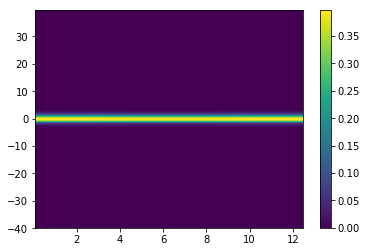

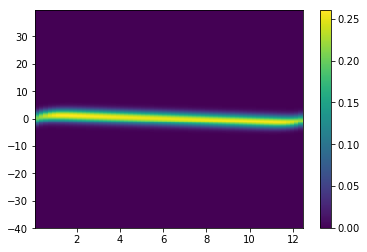

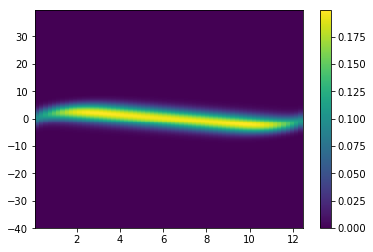

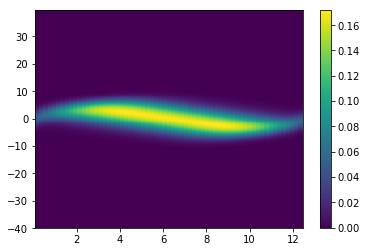

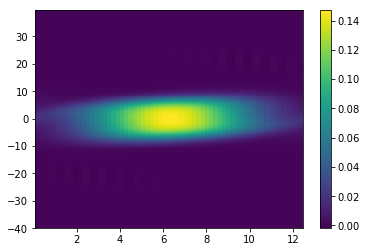

In [344]:
start = 0
stop = -1
plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,0])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,1])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,2])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,3])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,4])
plt.colorbar()
plt.show()

These plots show the distribution function at certain times.  It blows up shortly after this; we may need to use a different method than Lax-Friedrichs or use even smaller time step.  Next, we repeat this while actually computing the electric field.

In [367]:
Uplot = np.zeros((nv,nx,5))
Efield = np.zeros((nx,5))
U = np.zeros((nv,nx)) 
U = initial_u2(X,V)
U[0,:] = 0.0
U[-1,:] = 0.0
dt = 1/50
Uplot[:,:,0] = U
E = compute_electric_field(U,977)
Efield[:,0] = E[62,:]
U = FV_step_3(U,V,E,dt,dx,dv)
steps = 110
for i in range(steps):
    E = compute_electric_field(U,977)
    U = FV_step_3(U,V,E,dt,dx,dv)
    
    if i == 10:
        Uplot[:,:,1] = U
        Efield[:,1] = E[62,:]
        
    if i == 25:
        Uplot[:,:,2] = U
        Efield[:,2] = E[62,:]
        
    if i == 40:
        Uplot[:,:,3] = U
        Efield[:,3] = E[62,:]
        
    if i == 89:
        Uplot[:,:,4] = U
        Efield[:,4] = E[62,:]

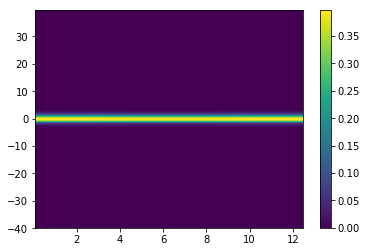

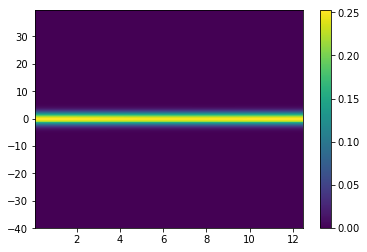

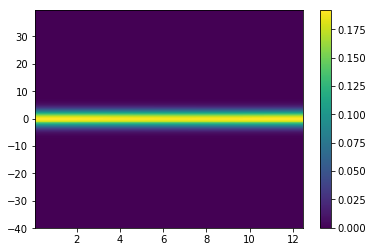

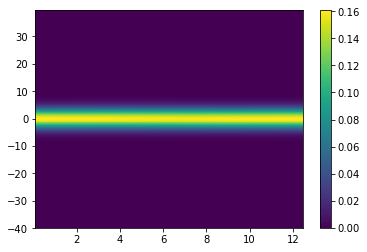

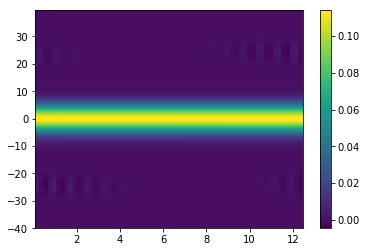

In [368]:
start = 0
stop = -1
plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,0])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,1])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,2])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,3])
plt.colorbar()
plt.show()

plt.pcolor(X[start:stop,:],V[start:stop,:],Uplot[start:stop,:,4])
plt.colorbar()
plt.show()

It appears the electric field causes the line to "thicken" so that the particles are more likely to have nonzero velocity (but not much).  They still remain approximately uniform across the spatial domain however.  The last plot shows them on their way to blowing up.

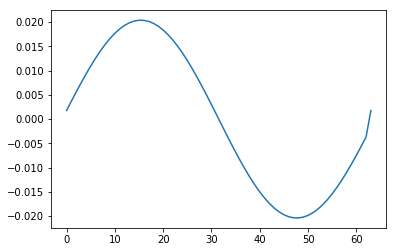

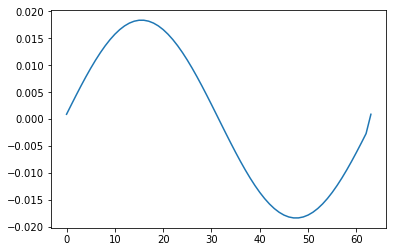

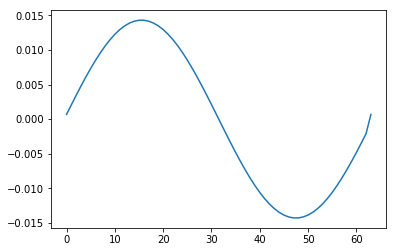

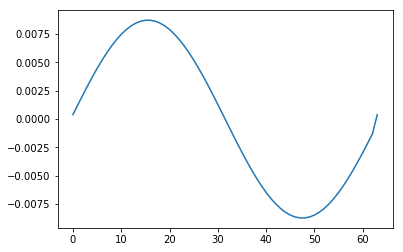

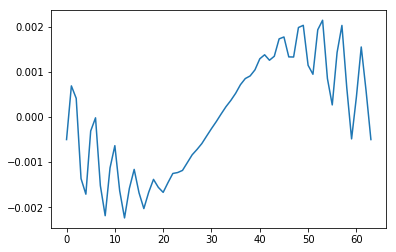

In [366]:
plt.plot(Efield[:,0])
plt.show()

plt.plot(Efield[:,1])
plt.show()

plt.plot(Efield[:,2])
plt.show()

plt.plot(Efield[:,3])
plt.show()

plt.plot(Efield[:,4])
plt.show()

These plots are of the electric fields themselves.  The periodicity seems a little "forced" at the right end, we probably need a more accurate integration method for the density.  The electric field also begins to blow up as well.  Again, we need more accurate integration and need to make sure that
\begin{equation}
\int_0^L\int_{-\infty}^{\infty}f dvdx = L
\end{equation}
holds as we progress forward in time